## requirements:
- tensorflow (latest)
- nltk
- sklearn
- numpy 
- pandas
- seaborn
- matplotlib

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
nltk.download('stopwords')

In [1]:
import os
import shutil
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from official.nlp import optimization  # to create AdamW optimizer

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
tf.get_logger().setLevel('ERROR')

In [2]:
main_data=pd.read_csv("sarcasm_v2\\GEN-sarc-notsarc.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
data["class"] = data["class"].map(classes)
data

,class,text
0,0,"If that's true, then Freedom of Speech is doom..."
1,0,Neener neener - is it time to go in from the p...
2,0,"Just like the plastic gun fear, the armour pie..."
3,0,So geology is a religion because we weren't he...
4,0,Well done Monty. Mark that up as your first ev...
...,...,...
6515,1,depends on when the baby bird died. run alon...
6516,1,"ok, sheesh, to clarify, women who arent aborti..."
6517,1,so.. eh?? hows this sound? will it fly w...
6518,1,"I think we should put to a vote, the right of ..."


In [3]:
ps = PorterStemmer()

In [4]:
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext
data['text'] = data['text'].apply(clean_text)

In [5]:
X=data['text']
y=data['class']
X=np.array(X)
y=np.asarray(y).astype('int32')#.reshape((-1,1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print('Train data len:'+str(len(X_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print('Test data len:'+str(len(X_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train data len:5216
Class distribution
1    2616
0    2600
dtype: int64
Test data len:1304
Class distribution
0    660
1    644
dtype: int64


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
print('Train data len:'+str(len(X_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution\n'+str((pd.Series(y_valid)).value_counts()))
print('Test data len:'+str(len(X_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train data len:4172
Class distribution
0    2087
1    2085
dtype: int64
Valid data len:1044
Class distribution
1    531
0    513
dtype: int64
Test data len:1304
Class distribution
0    660
1    644
dtype: int64


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ["If that's true, then Freedom of Speech is doomed. Harassment is subjective. Now I can claim that a book I don't like is harassing me, and it will be banned."]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2065 2008 1005 1055 2995 1010 2059 4071 1997 4613 2003]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.08723654  0.03913086 -0.26049614 -0.07701701  0.06620201 -0.2776949
  0.35507476 -0.0381389   0.03602449  0.6489038  -0.2098405  -0.15682086]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.24120495  0.989287    0.40126505 ... -0.7295184  -0.7426274
  -0.6539644 ]
 [-0.0636165   0.3070845   0.0113074  ... -0.8203864   0.26046398
   0.15205911]
 [ 0.30553073  0.07530826  0.64375734 ... -0.5358221   0.41741717
  -0.7072141 ]
 ...
 [-0.19246289  0.37028039  0.20879698 ... -0.81123805  0.1361109
  -1.0395026 ]
 [ 0.14647554  1.2313826  -0.5682717  ...  0.1338565   0.07819712
  -0.40188554]
 [-0.1162461   1.4800082   0.91525835 ...  0.4054372   0.7852653
   1.5100937 ]]


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5461169]], shape=(1, 1), dtype=float32)


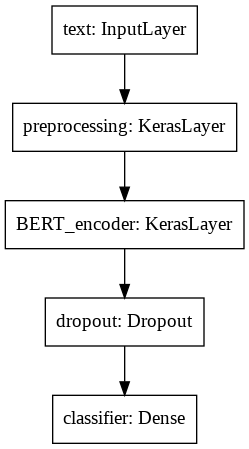

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=valid_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/5
163/163 [==============================] - 11097s 68s/step - loss: 0.5954 - binary_accuracy: 0.6586 - val_loss: 0.5122 - val_binary_accuracy: 0.7347
Epoch 2/5
163/163 [==============================] - 11350s 70s/step - loss: 0.4448 - binary_accuracy: 0.7845 - val_loss: 0.5527 - val_binary_accuracy: 0.7431
Epoch 3/5
 31/163 [====>.........................] - ETA: 2:24:06 - loss: 0.4093 - binary_accuracy: 0.8196

In [1]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

NameError: ignored

In [ ]:
test_data=pd.read_csv("sarcasm_v2\\HYP-sarc-notsarc.csv")
test_data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
test_data["class"] = test_data["class"].map(classes)
test_data

In [ ]:
test_data['text'] = test_data['text'].apply(clean_text)

In [ ]:
test_X=test_data['text']
test_y=test_data['class']
test_X=np.array(test_X)
test_y=np.asarray(test_y).astype('int32')

In [ ]:
test_tf = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(32)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_tf)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
test_data2=pd.read_csv("sarcasm_v2\\RQ-sarc-notsarc.csv")
test_data2.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
test_data2["class"] = test_data2["class"].map(classes)
test_data2

In [ ]:
test_data2['text'] = test_data2['text'].apply(clean_text)
test2_X=test_data2['text']
test2_y=test_data2['class']
test2_X=np.array(test2_X)
test2_y=np.asarray(test2_y).astype('int32')

In [ ]:
test2_tf = tf.data.Dataset.from_tensor_slices((test2_X,test2_y)).batch(32)
loss, accuracy = classifier_model.evaluate(test2_tf)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')